In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.max_open_warning'] = 30

select results file and get necessary parameters

In [16]:
# magnetometer GLM
#-----------------
# trialregs_dot = 0
# resfile = helpers.resultsdir + '/meg_sequential_201703011624.h5'

# trialregs_dot = 0, baseline = None
# resfile = helpers.resultsdir + '/meg_sequential_201703161743.h5'

# trialregs_dot = 5, baseline = None
# resfile = helpers.resultsdir + '/meg_sequential_201703161307.h5'

# trialregs_dot = 5
# resfile = helpers.resultsdir + '/meg_sequential_201703011927.h5'

# trialregs_dot = 0, baseline = None, choice flipped dot_x and accev
# resfile = helpers.resultsdir + '/meg_sequential_201705311314.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, 
# choice flipped dot_x and accev, move_dist, sum_dot_y, constregs=0 for 1st dot
#resfile = helpers.resultsdir + '/meg_sequential_201707031205.h5'

# source GLM
#-----------
# trialregs_dot = 5, baseline = (-0.3, 0), choice flipped dot_x and accev
# resfile = helpers.resultsdir + '/source_sequential_201706141650.h5'

# trialregs_dot = 5, baseline = (-0.3, 0), choice flipped dot_x and accev, move_dist, sum_dot_y_prev
# resfile = helpers.resultsdir + '/source_sequential_201706191442.h5'

# trialregs_dot = 5, baseline = (-0.3, 0), choice flipped dot_x and accev, move_dist, sum_dot_y_prev
# constregs=0 for 1st dot
# resfile = helpers.resultsdir + '/source_sequential_201706201654.h5'

# label mode = (abs)max, baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, 
# move_dist, sum_dot_y, constregs=0 for 1st dot
# resfile = helpers.resultsdir + '/source_sequential_201706281100.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, move_dist, 
# sum_dot_y, constregs=0 for 1st dot, 
# label_tc normalised across trials, times and subjects
# resfile = helpers.resultsdir + '/source_sequential_201707031206.h5.tmp'

# label mode = mean, baseline (-0.3, 0), only first 3 dots, 
# trialregs_dot=0, source GLM, sum_dot_y, motoprep, constregs=0 for 1st dot, 
# subject-specific normalisation of DM without centering and scaling by std
# label_tc normalised across trials, times and subjects
#resfile = helpers.resultsdir + '/source_sequential_201709011758.h5'

# label mode = mean, baseline (-0.3, 0), first 5 dots, 
# trialregs_dot=0, source GLM, sum_dot_y, constregs=0 for 1st dot, 
# subject-specific normalisation of DM without centering and scaling by std
# label_tc normalised across trials, times and subjects
resfile = helpers.resultsdir + '/source_sequential_201709061827.h5'

#evoked = helpers.load_evoked_container(window=pd.read_hdf(resfile, 'window'))
evoked = helpers.load_evoked_container(window=[0, 0.9])

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


plotting functions

In [3]:
stylecycler = cycle([':', '--', '-.'])
def plot_minmax_regressors(results, r_names, measure, nperm=0, mode='absmax'):
    if mode == 'max':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').max(
            level='time').plot(y=r_names);
    elif mode == 'min':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').min(
            level='time').abs().plot(y=r_names);
    elif mode == 'absmax':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).max(level='time').plot(y=r_names)
    elif mode == 'absmean':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).mean(level='time').plot(y=r_names)
        
    cols = [l.get_color() for l in ax.get_lines()]

    nperm += 1
    
    for perm in perms[1:nperm]:
        if mode == 'max':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').max(
                level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'min':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').min(
                level='time').abs().plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmax':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).max(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmean':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).mean(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))

    lines = ax.get_lines()
    for i in range(len(r_names)):
        col = lines[i].get_color()
        for perm in perms[1:nperm]:
            lines[i + perm * len(r_names)].set_color(col)

def show_topology_at_peaks(results, r_name, measure, mode='absmax', order=4, vmin=-.1, vmax=.1):
    if mode == 'absmax':
        data = results.loc[0, (measure, r_name)].abs().max(level='time')
    elif mode == 'absmean':
        data = results.loc[0, (measure, r_name)].abs().mean(level='time')
    elif mode == 'max':
        data = results.loc[0, (measure, r_name)].max(level='time')
    else:
        data = results.loc[0, (measure, r_name)].min(level='time').abs()
    
    plt.figure()
    ax = data.plot(title=measure);
    
    # identify local maxima
    times = data.index[scipy.signal.argrelextrema(data.values, 
                                                  np.greater, order=order)] / 1000
    
    data = results.loc[0, (measure, r_name)]
    ev = mne.EvokedArray(data.values.reshape(102, data.index.levels[1].size), 
                         evoked.info, tmin=data.index.levels[1][0], 
                         nave=480*5, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=vmin, vmax=vmax, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit=measure, 
                          outlines='skirt');
    

def plot_single_signal(fl_data, sl_data, label, r_name, ax=None):
    dat = fl_data.loc[(0, label, slice(None)), 
                      (slice(None), 'beta', r_name)]
    times = dat.index.get_level_values('time')
    
    if ax is None:
        fig, ax = plt.subplots()
        
    l = ax.plot(times, dat, color='.7', label='single subjects')
    l1 = ax.plot(times, sl_data.loc[(slice(1,3), label, slice(None)), ('mean', r_name)]
                               .reset_index('permnr')
                               .pivot(columns='permnr'), 
                 ':k', label='mean (permuted data)')
    l2 = ax.plot(times, sl_data.loc[(0, label, slice(None)), ('mean', r_name)], 
                 'k', lw=2, label='mean')
    
    ax.legend([l[0], l1[0], l2[0]], ['single subjects', 'mean (permuted data)', 'mean']);
    ax.set_title(label)
    ax.set_xlabel('time from dot onset (ms)')
    ax.set_ylabel('beta of ' + r_name + ' (z)')

# Second level analysis

this scales the betas by their standard error and then averages across subjects to get the second level mean

In [30]:
first_level = pd.read_hdf(resfile, 'first_level')
flt = (  first_level.xs('beta', level='measure', axis=1) 
       / first_level.xs('bse', level='measure', axis=1))
second_level = pd.concat([flt.mean(level='regressor', axis=1), 
                          flt.std(level='regressor', axis=1)], keys=['mean', 'std'], names=['measure'], axis=1)

del flt
perms = second_level.index.levels[0]
second_level.head()

measure                  mean                                             \
regressor           abs_dot_x abs_dot_y     accev accev_cflip accsur_pca   
permnr channel time                                                        
0      MEG0111 0     0.184867 -0.033029  0.004541    0.039324   0.081625   
               10    0.177010 -0.076789 -0.211375   -0.101515   0.222277   
               20    0.089827  0.175774 -0.306074   -0.228747   0.059146   
               30    0.015219  0.161020 -0.120363   -0.179160  -0.132462   
               40   -0.058044  0.162437  0.478668   -0.184015   0.136222   

measure                                                                  \
regressor               dot_x dot_x_cflip     dot_y   entropy intercept   
permnr channel time                                                       
0      MEG0111 0     0.244129    0.022031  0.060700 -0.072719  0.733998   
               10    0.098433    0.112576  0.042184 -0.096820  1.223689   
               20   -0.012904    0.172407  0.021205 -0.004851  1.257729   
               30   -0.025117    0.076158 -0.139637  0.054498  0.813352   
               40   -0.223763    0.158423 -0.271846  0.241620  0.296570   

measure                ...            std                                  \
regressor              ...     accsur_pca     dot_x dot_x_cflip     dot_y   
permnr channel time    ...                                                  
0      MEG0111 0       ...       1.195805  0.946591    1.046898  0.873289   
               10      ...       0.964020  1.087117    0.871139  0.998597   
               20      ...       0.958060  1.006996    0.998551  1.064099   
               30      ...       1.031227  1.059929    1.002853  1.055750   
               40      ...       1.229261  1.171590    0.975204  0.954775   

measure                                                                     \
regressor             entropy intercept move_dist  response sum_dot_y_prev   
permnr channel time                                                          
0      MEG0111 0     1.612272  3.377578  1.030662  0.894157       1.243747   
               10    1.790703  3.505660  1.040656  1.037323       1.105923   
               20    1.832610  3.758810  1.095963  0.907990       1.390195   
               30    1.792990  3.750441  1.101416  0.826077       1.519726   
               40    1.660654  3.892449  1.302065  0.847913       1.165518   

measure                         
regressor           trial_time  
permnr channel time             
0      MEG0111 0      1.370545  
               10     1.601082  
               20     1.590539  
               30     1.478316  
               40     1.195718  

[5 rows x 28 columns]

standard analysis: average betas across subjects to get the second level mean

In [17]:
first_level = pd.read_hdf(resfile, 'first_level')
second_level = pd.read_hdf(resfile, 'second_level')
perms = second_level.index.levels[0]
second_level.head()

measure                 mean                                          \
regressor          abs_dot_x abs_dot_y     accev     dot_x     dot_y   
permnr label  time                                                     
0      ???-lh 0    -0.001481  0.002696  0.000250  0.000358  0.001928   
              10   -0.001706 -0.000965 -0.005511 -0.002597 -0.002741   
              20   -0.004747  0.000949 -0.007526 -0.002281  0.000021   
              30   -0.002606  0.004087 -0.007265  0.005280  0.000789   
              40   -0.004154  0.000837 -0.003877  0.000069 -0.000646   

measure                                       mlog10p                      \
regressor          intercept sum_dot_y_prev abs_dot_x abs_dot_y     accev   
permnr label  time                                                          
0      ???-lh 0     0.030267       0.008236  0.152080  0.316713  0.015347   
              10    0.037165       0.007295  0.138435  0.094549  0.415735   
              20    0.037271       0.004785  0.496569  0.093512  0.855068   
              30    0.025417       0.001813  0.243345  0.634023  1.026180   
              40    0.023599       0.002476  0.425996  0.090223  0.374103   

measure                 ...                                           \
regressor               ...           dot_y intercept sum_dot_y_prev   
permnr label  time      ...                                            
0      ???-lh 0         ...        0.238805  1.738532       1.381097   
              10        ...        0.325846  2.640312       0.906140   
              20        ...        0.001930  3.020776       0.488024   
              30        ...        0.086860  1.694870       0.167151   
              40        ...        0.059020  1.380248       0.255556   

measure                  std                                          \
regressor          abs_dot_x abs_dot_y     accev     dot_x     dot_y   
permnr label  time                                                     
0      ???-lh 0     0.022571  0.022118  0.033276  0.022906  0.019956   
              10    0.028264  0.022533  0.036417  0.018955  0.021981   
              20    0.027340  0.022392  0.028990  0.018529  0.021676   
              30    0.026557  0.019582  0.024578  0.019270  0.019918   
              40    0.026929  0.020390  0.027836  0.021151  0.023363   

measure                                      
regressor          intercept sum_dot_y_prev  
permnr label  time                           
0      ???-lh 0     0.071059       0.022650  
              10    0.065551       0.026957  
              20    0.059897       0.027931  
              30    0.060722       0.025450  
              40    0.064925       0.024219  

[5 rows x 21 columns]

In [77]:
# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
tvals = (second_level.xs('mean', axis=1, level='measure')  / 
         second_level.xs('std', axis=1, level='measure') * np.sqrt(34))
tvals['accev'] = -tvals['accev']

In [78]:
absmean = tvals.xs(0, level='permnr').abs().mean(level='time')

<IPython.core.display.Javascript object>


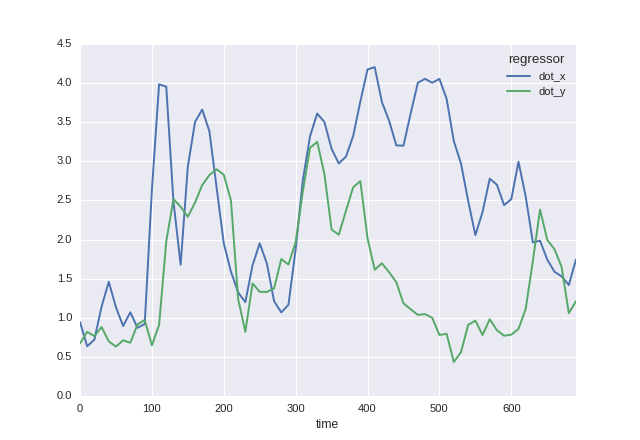

In [79]:
absmean.plot.line(y=['dot_x', 'dot_y']);

<IPython.core.display.Javascript object>


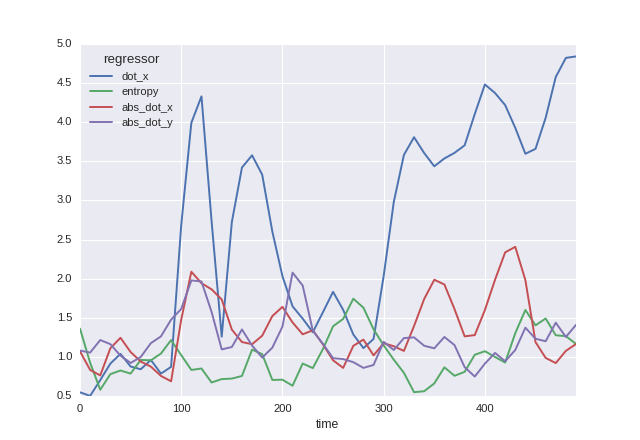

In [10]:
absmean.plot.line(y=['dot_x', 'entropy', 'abs_dot_x', 'abs_dot_y']);

In [11]:
tvals.loc[(0, slice(None), 120), 'abs_dot_x'].abs().sort_values(ascending=False)

permnr  channel  time
0       MEG2511  120     7.413815
        MEG2331  120     6.682879
        MEG2531  120     5.993544
        MEG1731  120     5.865078
        MEG1941  120     5.838971
        MEG2541  120     5.813320
        MEG2521  120     5.764209
        MEG2321  120     4.888818
        MEG2631  120     4.756830
        MEG2341  120     4.623184
        MEG1921  120     4.470360
        MEG1721  120     4.221207
        MEG2641  120     4.124759
        MEG1641  120     4.054166
        MEG2131  120     3.938256
        MEG0241  120     3.661978
        MEG2621  120     3.585898
        MEG1911  120     3.537971
        MEG1611  120     3.532929
        MEG2611  120     3.444703
        MEG2041  120     3.260631
        MEG1931  120     3.251269
        MEG2431  120     3.246807
        MEG1521  120     3.207854
        MEG1511  120     3.072374
        MEG2011  120     2.974807
        MEG1431  120     2.739952
        MEG2021  120     2.716316
        MEG1441  120     2

### describe genuine regressors

In [11]:
measure = 'mean'

second_level.xs(measure, axis=1, level='measure').xs(0, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,move_dist,response,sum_dot_y_prev,trial_time
count,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000
mean,-0.002019,0.000515,-0.001118,-0.003630,-0.001932,0.000940,0.003512,-0.002474,0.006336,1.988070,-0.000553,0.001975,-0.000895,0.004201
std,0.004461,0.004719,0.005586,0.008565,0.005825,0.004465,0.005051,0.004392,0.012226,0.246045,0.006337,0.007272,0.005354,0.022311
min,-0.023731,-0.021412,-0.024913,-0.043250,-0.027620,-0.017275,-0.014570,-0.021536,-0.033210,1.270937,-0.024200,-0.026033,-0.022599,-0.058640
25%,-0.004996,-0.002462,-0.004817,-0.008767,-0.005757,-0.002081,0.000023,-0.005428,-0.001897,1.826186,-0.004789,-0.002841,-0.004379,-0.013950
50%,-0.001938,0.000707,-0.000977,-0.002430,-0.001824,0.000920,0.003470,-0.002427,0.004623,1.970046,-0.000548,0.001917,-0.000895,0.003055
75%,0.001027,0.003699,0.002627,0.002551,0.002125,0.003968,0.006839,0.000560,0.012477,2.101617,0.003710,0.006800,0.002674,0.020828
max,0.014149,0.017235,0.018406,0.021346,0.018331,0.021930,0.022031,0.014545,0.061729,3.055098,0.025575,0.033494,0.018926,0.082056


### describe regressors of first permutation

In [12]:
second_level.xs(measure, axis=1, level='measure').xs(1, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,move_dist,response,sum_dot_y_prev,trial_time
count,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000,25340.000000
mean,-0.001014,-0.001070,-0.000826,-0.005185,-0.001908,0.000419,0.002559,-0.001381,0.006620,1.987724,-0.001299,-0.000705,-0.000579,-0.000162
std,0.004547,0.004409,0.005297,0.008685,0.005888,0.004514,0.005655,0.004110,0.011931,0.245950,0.006240,0.007622,0.004752,0.006802
min,-0.017316,-0.022658,-0.021804,-0.041343,-0.023895,-0.020648,-0.015701,-0.017454,-0.028778,1.272527,-0.025513,-0.029558,-0.019011,-0.027161
25%,-0.004069,-0.004027,-0.004358,-0.009363,-0.005911,-0.002612,-0.001385,-0.004137,-0.001582,1.826189,-0.005548,-0.005869,-0.003765,-0.004684
50%,-0.001032,-0.001014,-0.000737,-0.003624,-0.001927,0.000472,0.002118,-0.001354,0.005460,1.969879,-0.001317,-0.000757,-0.000557,-0.000184
75%,0.001993,0.001934,0.002741,0.000720,0.002076,0.003461,0.006065,0.001410,0.013490,2.100983,0.002940,0.004456,0.002562,0.004370
max,0.017885,0.017111,0.021242,0.017625,0.021247,0.018091,0.026038,0.015800,0.058396,3.056597,0.023467,0.027720,0.020503,0.026429


## Show evolution of max (across channels) through the trial

principle regressors of interest

<IPython.core.display.Javascript object>


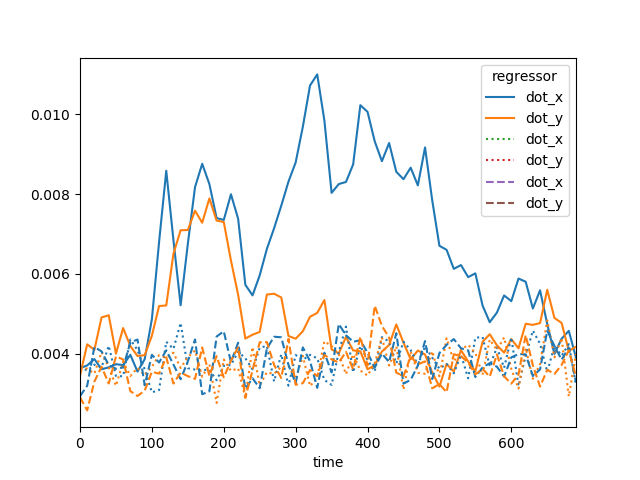

In [7]:
reg = ['dot_x', 'dot_y']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

<IPython.core.display.Javascript object>


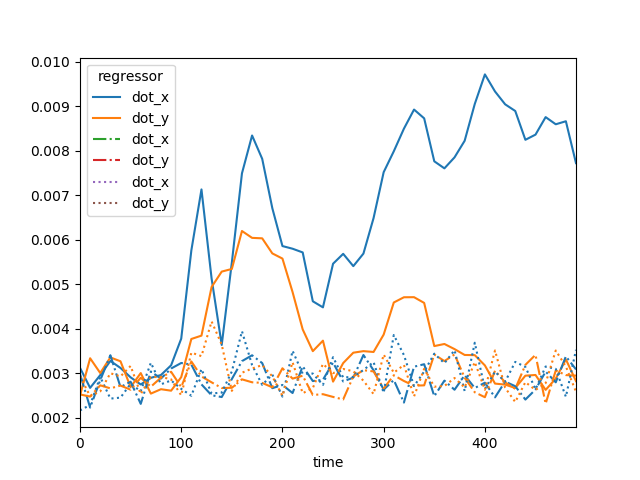

In [18]:
reg = ['dot_x', 'dot_y']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

<IPython.core.display.Javascript object>


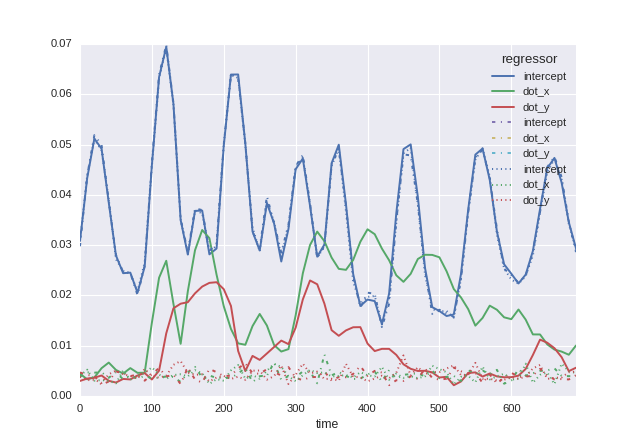

In [72]:
reg = ['intercept', 'dot_x', 'dot_y']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

surprise regressors

<IPython.core.display.Javascript object>


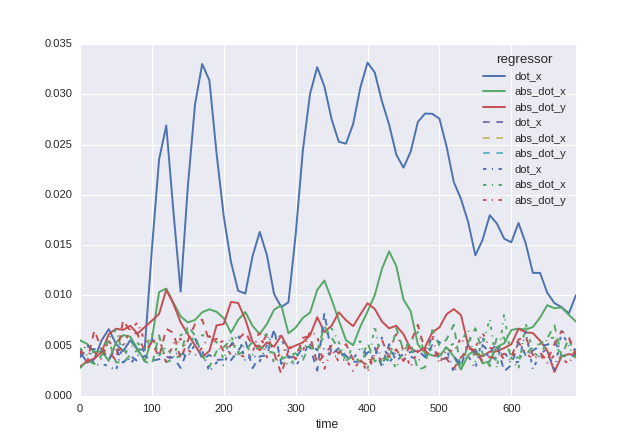

In [73]:
plot_minmax_regressors(second_level, ['dot_x', 'abs_dot_x', 'abs_dot_y'], 
                       measure, nperm=2, mode='absmean')

trial regressors

<IPython.core.display.Javascript object>


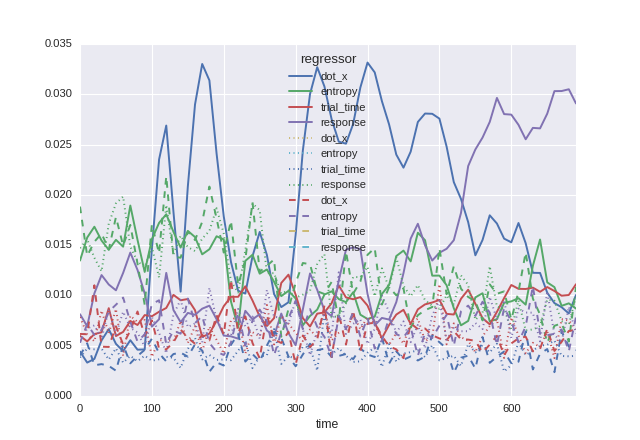

In [74]:
plot_minmax_regressors(second_level, ['dot_x', 'entropy', 'trial_time', 'response'], 
                       measure, nperm=2, mode='absmean')

choice flipped evidence regressors

<IPython.core.display.Javascript object>


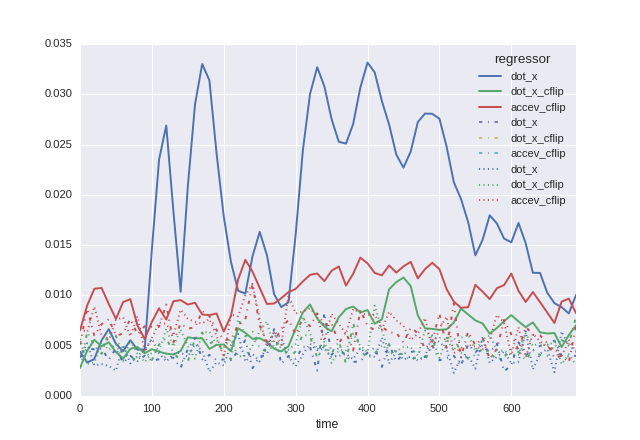

In [75]:
plot_minmax_regressors(second_level, ['dot_x', 'dot_x_cflip', 'accev_cflip'], 
                       measure, nperm=2, mode='absmean')

purely perceptual regressors

<IPython.core.display.Javascript object>


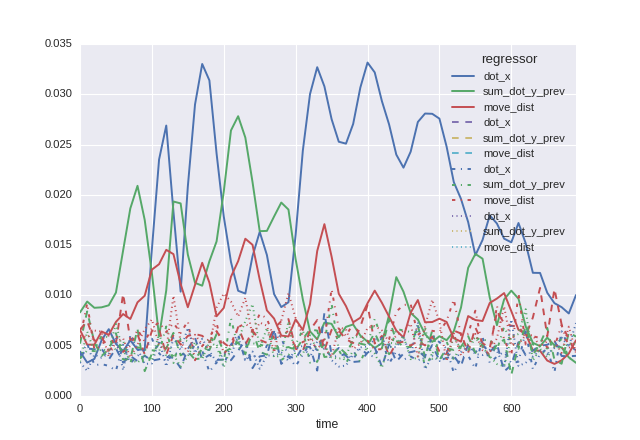

In [76]:
plot_minmax_regressors(second_level, ['dot_x', 'sum_dot_y_prev', 'move_dist'], 
                       measure, nperm=3, mode='absmean')

## Check distribution of a signal signal across time and subjects

<IPython.core.display.Javascript object>


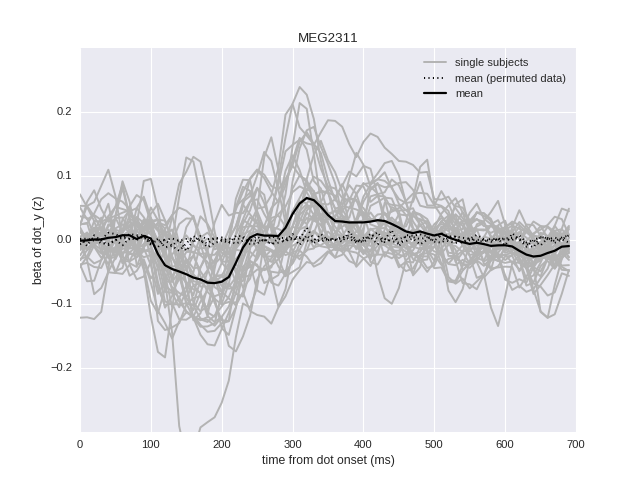

In [70]:
r_name = 'dot_y'
channel = 'MEG2311'
fig, axes = plt.subplots(1, figsize=[8, 6])
plot_single_signal(first_level, second_level, channel, r_name, axes)
axes.set_ylim([-0.3, 0.3]);

<IPython.core.display.Javascript object>


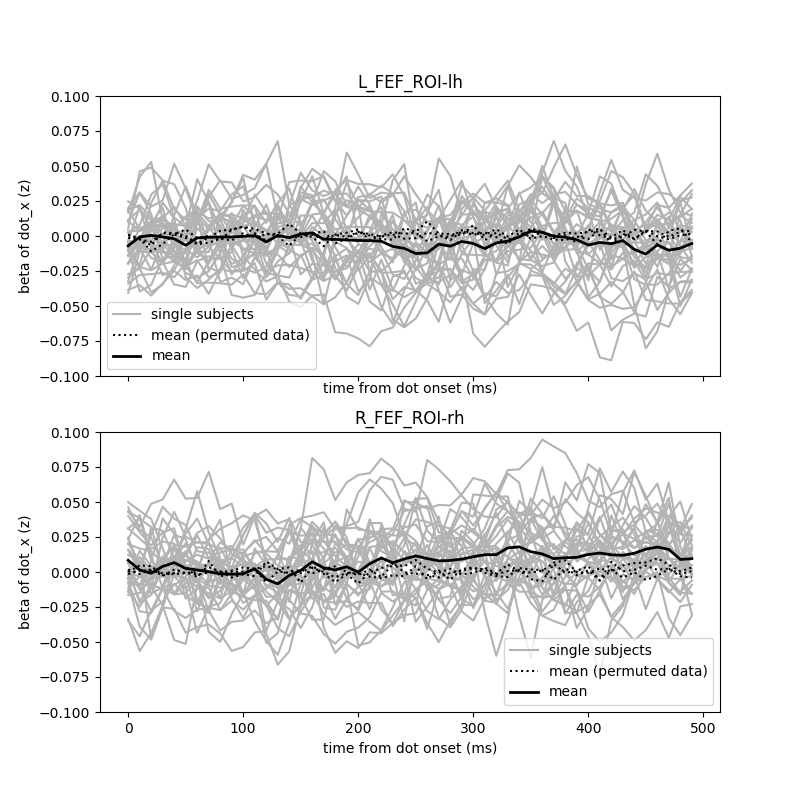

In [41]:
r_name = 'dot_x'
area = 'FEF'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

<IPython.core.display.Javascript object>


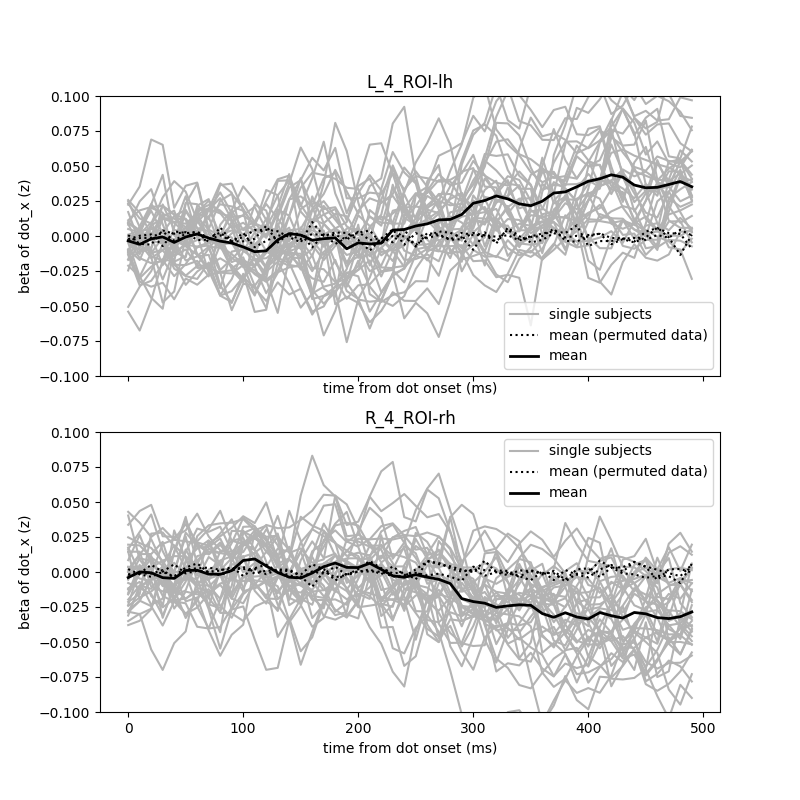

In [19]:
r_name = 'dot_x'
area = '4'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

<IPython.core.display.Javascript object>


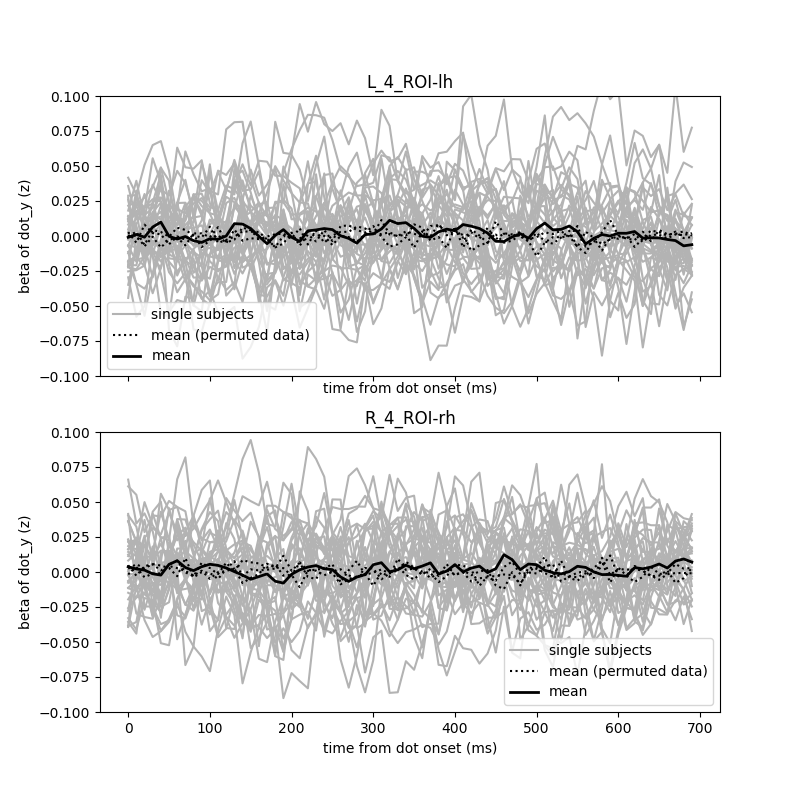

In [9]:
r_name = 'dot_y'
#area = 'LIPd'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

<IPython.core.display.Javascript object>


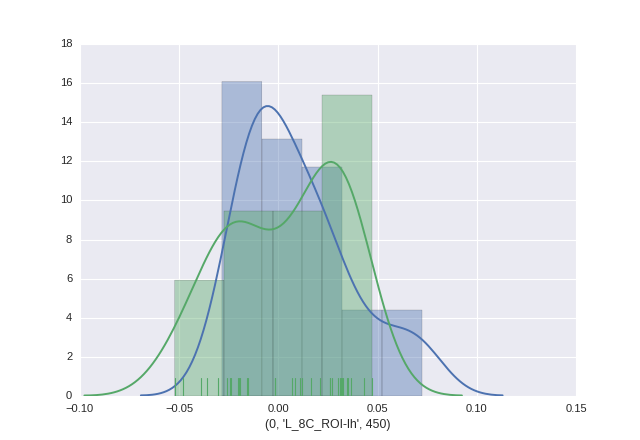

mean +- std of beta = 0.004 +- 0.029
t-value = 0.787


In [89]:
time = 450
fig, ax = plt.subplots()
fldata = first_level.loc[(0, 'R_%s_ROI-rh'%area, time), (slice(None), 'beta', r_name)]
sns.distplot(fldata)
fldata = first_level.loc[(0, 'L_%s_ROI-lh'%area, time), (slice(None), 'beta', r_name)]
sns.distplot(fldata, rug=True)
print('mean +- std of beta = {:.3f} +- {:.3f}'.format(fldata.mean(), fldata.std()))
print('t-value = {:.3f}'.format(fldata.mean() / (fldata.std() / np.sqrt(len(fldata)))))

### Is small variability across subjects related to the size of the area?

In [13]:
label_nv = pd.read_hdf('mne_subjects/fsaverage/bem/source_epochs_allsubs_HCPMMP1_201706131725.h5', 'label_nv')
label_nv.sort_index(axis=1, inplace=True)

In [29]:
label_data = pd.concat([label_nv.loc[2], 
                        first_level.loc[(0, slice(None), slice(None)), 
                                        (slice(None), 'beta', 'dot_x')]
                        .std(axis=1).mean(level='label')], 
                       axis=1, keys=['nv', 'std'])

<IPython.core.display.Javascript object>


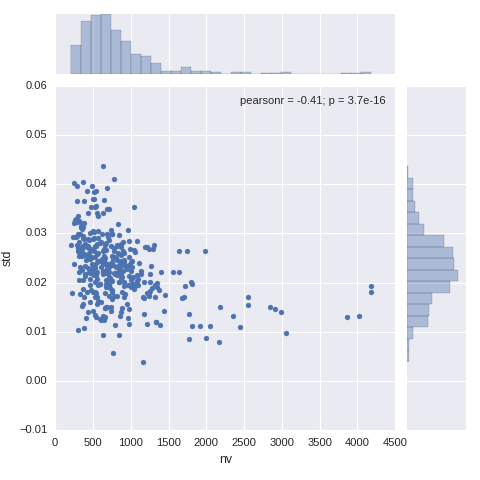

In [32]:
# ignoring the first two labels (whole hemispheres)
sns.jointplot('nv', 'std', data=label_data.iloc[2:]);

In [33]:
label_data[label_data.nv > 1500].sort_values('std')

,nv,std
label,,
L_1_ROI-lh,2162,0.008009
R_3a_ROI-rh,1770,0.008575
R_V3_ROI-rh,1989,0.008809
L_V2_ROI-lh,3052,0.009741
L_PFm_ROI-lh,2451,0.011062
R_1_ROI-rh,2045,0.011107
L_3a_ROI-lh,1812,0.011194
L_V3_ROI-lh,1920,0.011271
R_4_ROI-rh,3855,0.013031


In [36]:
label_data[(label_data.nv < 1000) & (label_data['std'] < 0.013)].sort_values('std')

,nv,std
label,,
R_PHT_ROI-rh,759,0.005639
R_9a_ROI-rh,637,0.009402
L_PFop_ROI-lh,839,0.009430
L_s6-8_ROI-lh,307,0.010462
R_MST_ROI-rh,385,0.010749
L_13l_ROI-lh,791,0.011394
L_8Av_ROI-lh,977,0.011599
R_a32pr_ROI-rh,602,0.012348
R_p10p_ROI-rh,640,0.012462


In [42]:
import pystan
folded_normal_stan = """
data {
 int<lower = 0> S;
 real y[S];
}

parameters {
  real<lower=0> mu;
  real<lower=0> sigma;
  real<lower=0, upper=1> theta;
}

model {
 sigma ~ normal(0, 5);
 mu ~ normal(0, 5);
 theta ~ beta(1, 1);
 
 for (s in 1:S)
     target += log_mix(theta,
                       normal_lpdf(y[s] |  mu, sigma),
                       normal_lpdf(y[s] | -mu, sigma));
}
"""

fit = pystan.stan(model_code=folded_normal_stan, 
                  data={'S': first_level.columns.levshape[0], 
                        'y': first_level.loc[(0, 'R_1_ROI-rh', 450), 
                                             (slice(None), 'beta', 'dot_x')].values},
                  iter=1000, chains=4)

In [98]:
area = 'V7'
time = 170
fit2 = pystan.stan(fit=fit, 
                   data={'S': first_level.columns.levshape[0], 
                         'y': first_level.loc[(0, 'R_{}_ROI-rh'.format(area), time), 
                                             (slice(None), 'beta', 'dot_x')].values},
                   iter=1000, chains=4)

mu_test_val = 0.0153
mu_p_large = 0.9960


<IPython.core.display.Javascript object>


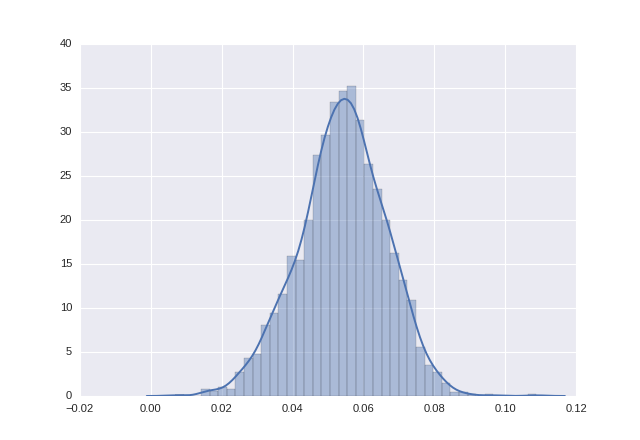

In [99]:
samples = fit2.extract()
print('mu_test_val = {:.4f}'.format(np.percentile(samples['mu'], 0.05)))
print('mu_p_large = {:.4f}'.format(np.mean(samples['mu'] > 0.02)))
fig, ax = plt.subplots()
sns.distplot(samples['mu']);

## Investigate topography

<IPython.core.display.Javascript object>


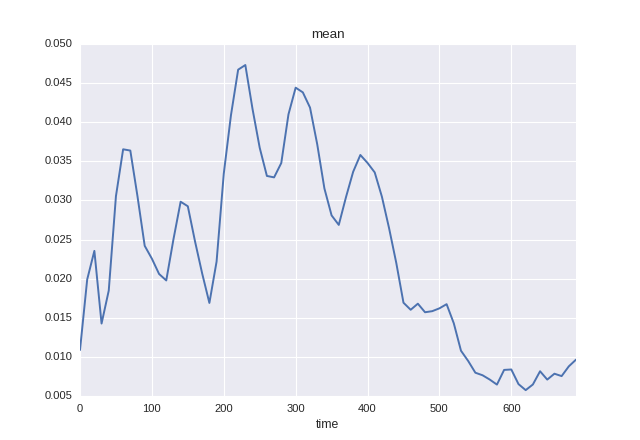

<IPython.core.display.Javascript object>


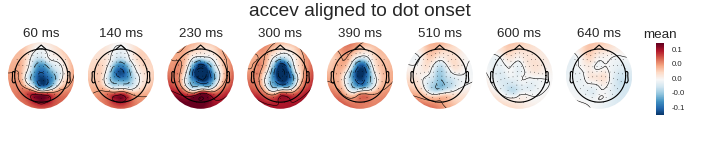

In [29]:
show_topology_at_peaks(second_level, 'accev', 'mean', mode='absmean', order=3)

<IPython.core.display.Javascript object>


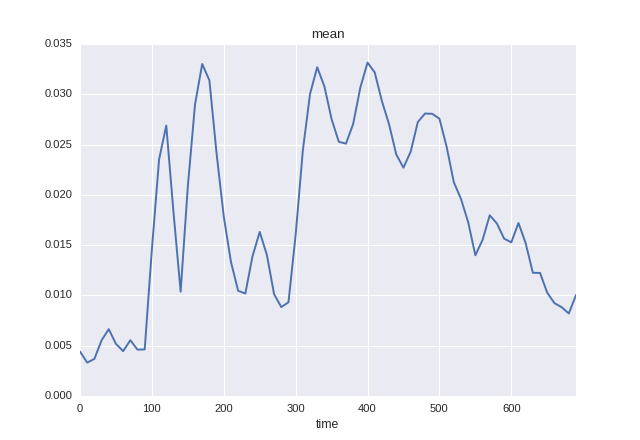

<IPython.core.display.Javascript object>


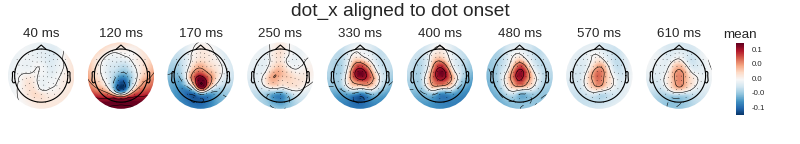

In [26]:
show_topology_at_peaks(second_level, 'dot_x', 'mean', mode='absmean', order=3, vmin=-0.1, vmax=0.1)

<IPython.core.display.Javascript object>


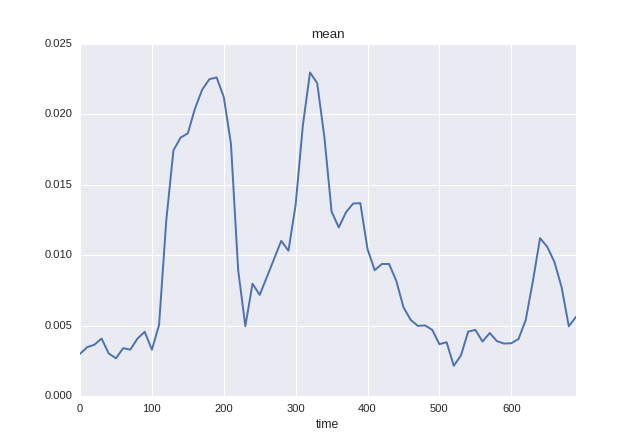

<IPython.core.display.Javascript object>


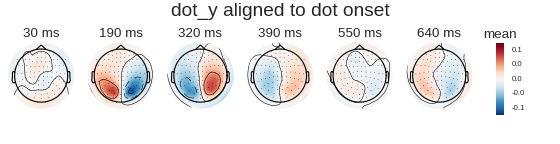

In [66]:
show_topology_at_peaks(second_level, 'dot_y', 'mean', mode='absmean', vmin=-0.1, vmax=0.1)

<IPython.core.display.Javascript object>


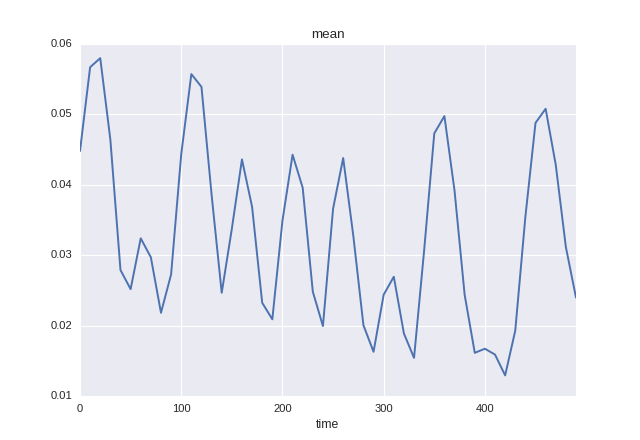

<IPython.core.display.Javascript object>


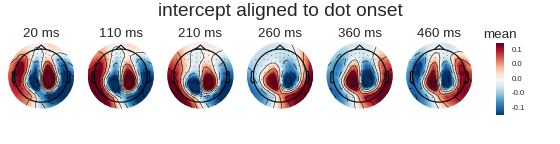

In [15]:
show_topology_at_peaks(second_level, 'intercept', 'mean', mode='absmean')

<IPython.core.display.Javascript object>


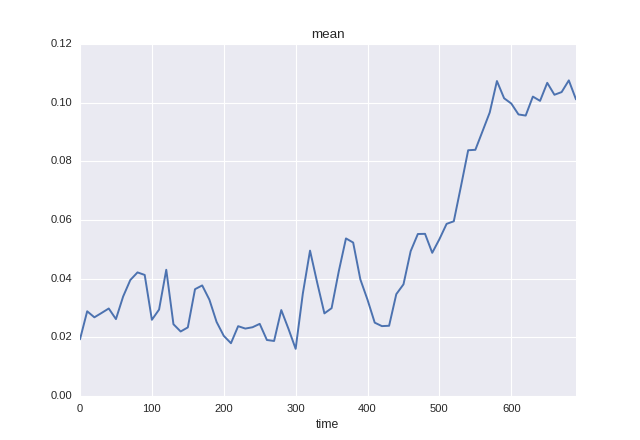

<IPython.core.display.Javascript object>


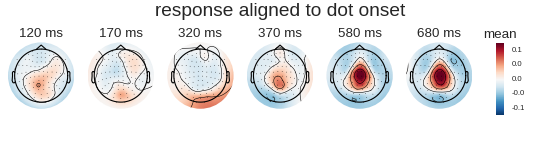

In [28]:
show_topology_at_peaks(second_level, 'response', 'mean')

# Check single subject results

In [6]:
first_level_diagnostics = pd.read_hdf(resfile, 'first_level_diagnostics')
first_level = pd.read_hdf(resfile, 'first_level')

In [12]:
first_level.columns.levels[1]

Index(['beta', 'bse'], dtype='object', name='measure')

In [16]:
sl2 = first_level.xs('beta', axis=1, level='measure').abs().mean(axis=1, level='regressor')
sl2.columns = pd.MultiIndex.from_product([['mean'], sl2.columns], names=['measure', 'regressor'])

In [17]:
sl2

measure                  mean                                           \
regressor           abs_dot_x abs_dot_y     accev accsur_pca     dot_x   
permnr channel time                                                      
0      MEG0111 0     0.022158  0.012504  0.024533   0.019484  0.019925   
               10    0.022488  0.012532  0.023444   0.019486  0.022248   
               20    0.022435  0.013733  0.024293   0.017851  0.017797   
               30    0.022644  0.015043  0.024593   0.019526  0.018390   
               40    0.023600  0.016181  0.026994   0.020993  0.022459   
               50    0.023433  0.016996  0.028071   0.020143  0.021211   
               60    0.024415  0.016914  0.032458   0.020104  0.019707   
               70    0.023440  0.015281  0.030786   0.020387  0.023479   
               80    0.022769  0.012878  0.026777   0.021327  0.021936   
               90    0.020980  0.013644  0.028592   0.021824  0.019572   
               100   0.020190  0.014850  0.027681   0.019746  0.017669   
               110   0.023361  0.016360  0.030478   0.018995  0.020706   
               120   0.024527  0.016010  0.034461   0.020332  0.023122   
               130   0.021414  0.014274  0.034417   0.019547  0.020442   
               140   0.017597  0.018806  0.033652   0.021554  0.024753   
               150   0.017374  0.024039  0.029476   0.021927  0.026715   
               160   0.018555  0.020946  0.031792   0.021616  0.028443   
               170   0.019754  0.021147  0.030950   0.022652  0.028036   
               180   0.019182  0.019710  0.033503   0.021616  0.028282   
               190   0.018583  0.017815  0.037354   0.021395  0.022876   
               200   0.017865  0.016684  0.038594   0.023677  0.021246   
               210   0.017156  0.015362  0.039711   0.027545  0.024445   
               220   0.017484  0.017648  0.041354   0.026696  0.027557   
               230   0.014749  0.021437  0.040499   0.022126  0.029691   
               240   0.016154  0.018396  0.033687   0.020626  0.026426   
               250   0.015876  0.019806  0.030013   0.019669  0.025245   
               260   0.018364  0.020088  0.034040   0.020611  0.024278   
               270   0.018079  0.016993  0.035319   0.022851  0.024178   
               280   0.021934  0.018374  0.036441   0.022122  0.025188   
               290   0.019908  0.022392  0.037218   0.020269  0.030143   
...                       ...       ...       ...        ...       ...   
5      MEG2641 200   0.022955  0.016129  0.020000   0.018347  0.015904   
               210   0.018303  0.017844  0.018402   0.018204  0.021340   
               220   0.022061  0.017334  0.016007   0.019140  0.014474   
               230   0.019969  0.017324  0.024013   0.018383  0.015008   
               240   0.021713  0.013452  0.016286   0.022685  0.016662   
               250   0.020280  0.013937  0.016386   0.020612  0.015531   
               260   0.025184  0.013193  0.016505   0.018598  0.018630   
               270   0.019006  0.017195  0.019143   0.017861  0.016480   
               280   0.020907  0.014484  0.014909   0.020747  0.018761   
               290   0.025323  0.015719  0.015030   0.017323  0.018526   
               300   0.020358  0.015214  0.020411   0.018700  0.017018   
               310   0.020996  0.017869  0.017199   0.013325  0.014941   
               320   0.019945  0.017449  0.017149   0.019696  0.017608   
               330   0.018963  0.017904  0.017821   0.018240  0.020135   
               340   0.015016  0.013771  0.015811   0.018444  0.019067   
               350   0.017917  0.015325  0.014546   0.018878  0.017495   
               360   0.019781  0.015261  0.016410   0.013542  0.020235   
               370   0.016964  0.019594  0.015949   0.017414  0.017642   
               380   0.017850  0.014603  0.015177   0.018865  0.013945   
               390   0.014656  0.013607  0.014239   0.015124  0.016424   
    

<IPython.core.display.Javascript object>


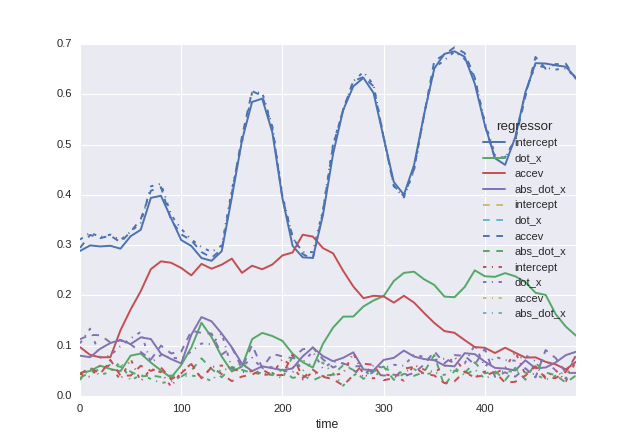

<IPython.core.display.Javascript object>


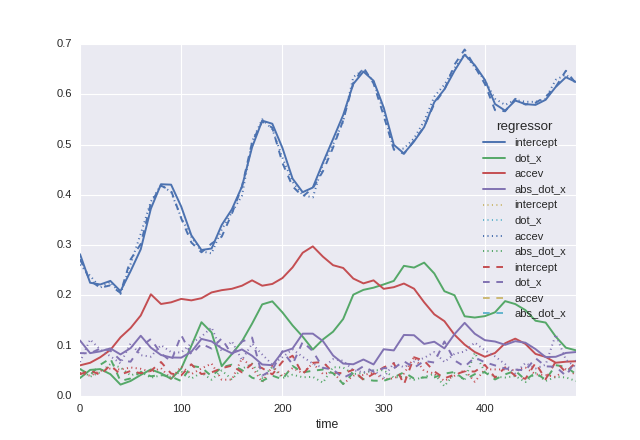

<IPython.core.display.Javascript object>


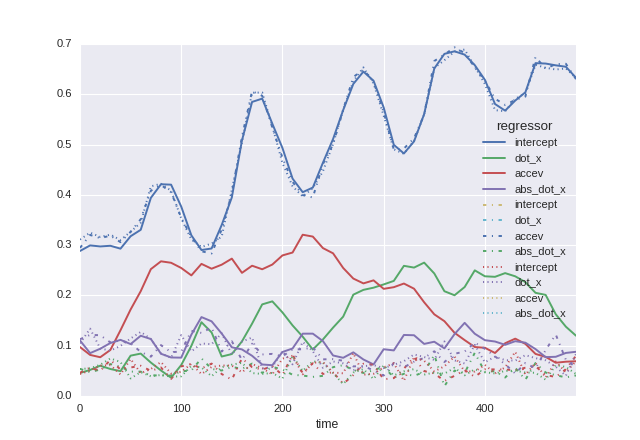

In [16]:
sub = 4
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='max')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='min')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='absmax')

## Determine relative 'power' of 20 and 60 ms peaks in intercept

In [17]:
times = first_level.index.levels[2]

# determine mean in 100 ms bins
for tbin in range(int(np.ceil(times[-1] / 100))):
    tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
    
    binmean = first_level.loc[(0, slice(None), tbin_times), 
        (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()
    
# first 200 ms


In [18]:
tbin=1
times = first_level.index.levels[2]
tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
first_level.loc[(0, slice(None), tbin_times), (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()

subject  measure  regressor
2        beta     intercept    0.389247
3        beta     intercept    0.264310
4        beta     intercept    0.424077
5        beta     intercept    0.432001
6        beta     intercept    0.558149
7        beta     intercept    0.336534
8        beta     intercept    0.398896
9        beta     intercept    0.399745
10       beta     intercept    0.294193
11       beta     intercept    0.296134
12       beta     intercept    0.620539
13       beta     intercept    0.384772
15       beta     intercept    0.426321
16       beta     intercept    0.557392
17       beta     intercept    0.504056
18       beta     intercept    0.559385
19       beta     intercept    0.409016
20       beta     intercept    0.470337
21       beta     intercept    0.324355
22       beta     intercept    0.394971
23       beta     intercept    0.330052
24       beta     intercept    0.417385
25       beta     intercept    0.604494
26       beta     intercept    0.555887
27       bet